In [1]:
pip install transformers torch huggingface_hub accelerate safetensors


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login

api_key = "**********" # Replace with your actual API key
login(api_key)

model_name = "mistralai/Mistral-7B-v0.1"
model_name = "mistralai/Mistral-7B-v0.1"

In [5]:
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.float16,
                                             device_map='auto',
                                             use_auth_token=True)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [8]:
def ask_mistral(question, max_new_tokens=20):
    """Asks the Mistral model a question and gets a response."""
    prompt = f"Q: {question}\nA:"

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, eos_token_id=tokenizer.eos_token_id)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # Extract only the first answer
    answer_lines = response.split("\n")
    return answer_lines[1] if len(answer_lines) > 1 else response

# Test question
question = "What is the capital of France?"
response = ask_mistral(question)

print("\nMistral's Answer:", response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Mistral's Answer: A: Paris


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name,use_auth_token=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from transformers import pipeline

# Load dataset (Replace 'churn_data.csv' with actual dataset path)
df = pd.read_csv("Sample_Churn_Data.csv")

# Preview dataset
print(df.head())

# Drop unnecessary columns (modify based on dataset)
df.drop(['CustomerID'], axis=1, inplace=True, errors='ignore')

# Handling categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values
df.fillna(df.median(), inplace=True)

# Split dataset into features and target
X = df.drop(columns=['Churn'])  # Features
y = df['Churn']  # Target (0 = No Churn, 1 = Churn)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Load a Generative AI Model (Hugging Face's GPT-2 for text generation)
gpt_model = pipeline("text-generation", model="gpt2")

# Define function to generate retention strategies
def generate_retention_strategy(customer_info):
    prompt = f"A customer is likely to churn with these details: {customer_info}. Provide a personalized retention strategy."
    response = gpt_model(prompt, max_new_tokens=50, num_return_sequences=1)
    return response[0]['generated_text']


# Example usage for generating retention strategy for a single customer
sample_customer = X_test[0]  # Pick a test sample
sample_info = {col: val for col, val in zip(X.columns, sample_customer)}
generated_strategy = generate_retention_strategy(sample_info)

print("\nGenerated Retention Strategy:\n", generated_strategy)


  CustomerID  Age  Gender  Subscription_Tenure  Monthly_Bill Payment_Method  \
0     CUST_1   56    Male                   15         88.10  Bank Transfer   
1     CUST_2   69    Male                   53        169.57     Debit Card   
2     CUST_3   46  Female                    7        181.00  Bank Transfer   
3     CUST_4   32    Male                    9         77.15    Credit Card   
4     CUST_5   60    Male                   51         55.01         PayPal   

   Customer_Support_Calls Has_Contract Internet_Service Streaming_Service  \
0                       6           No              NaN      Amazon Prime   
1                       5          Yes              DSL      Amazon Prime   
2                       3           No              DSL      Amazon Prime   
3                       8           No            Fiber           Netflix   
4                       5           No              DSL      Amazon Prime   

   Churn  
0      1  
1      0  
2      0  
3      0  
4      

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Retention Strategy:
 A customer is likely to churn with these details: {'Age': 1.369909899966145, 'Gender': 0.9704367948586523, 'Subscription_Tenure': -0.6753901568534944, 'Monthly_Bill': -0.5315626465987117, 'Payment_Method': -0.4024922359499621, 'Customer_Support_Calls': -0.18627639320305714, 'Has_Contract': 1.0151142067727545, 'Internet_Service': 0.038170163234975775, 'Streaming_Service': 1.3424297359421296}. Provide a personalized retention strategy. Your unique, personalized name & email address for your first phone call or call to a customer will give you a very personalized email address for your first call or call.

2. Provide a custom service plan (a "services plan" – that


In [2]:
df

,Age,Gender,Subscription_Tenure,Monthly_Bill,Payment_Method,Customer_Support_Calls,Has_Contract,Internet_Service,Streaming_Service,Churn
0,56,1,15,88.10,0,6,0,2,0,1
1,69,1,53,169.57,2,5,1,0,0,0
2,46,0,7,181.00,0,3,0,0,0,0
3,32,1,9,77.15,1,8,0,1,2,0
4,60,1,51,55.01,3,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,18,1,26,163.56,2,7,1,1,2,0
996,35,0,9,190.06,2,2,1,0,0,0
997,49,0,15,23.74,2,6,1,0,3,0
998,64,1,10,191.47,3,9,1,0,2,1


In [8]:
# Continuous columns (Numeric types)
continuous_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_cols

['Age',
 'Gender',
 'Subscription_Tenure',
 'Monthly_Bill',
 'Payment_Method',
 'Customer_Support_Calls',
 'Has_Contract',
 'Internet_Service',
 'Streaming_Service',
 'Churn']

In [10]:
# Categorical columns (Non-numeric types)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols

[]

<ipython-input-12-ca3fb76f361f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette="coolwarm")


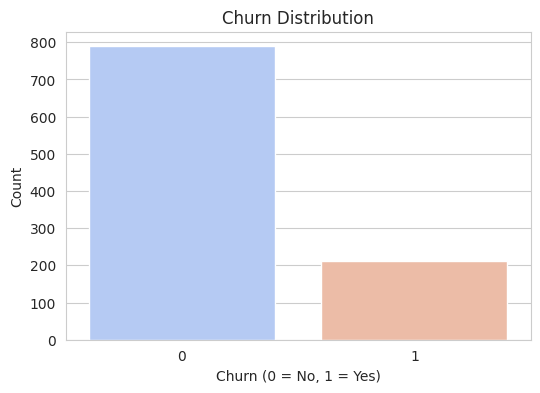

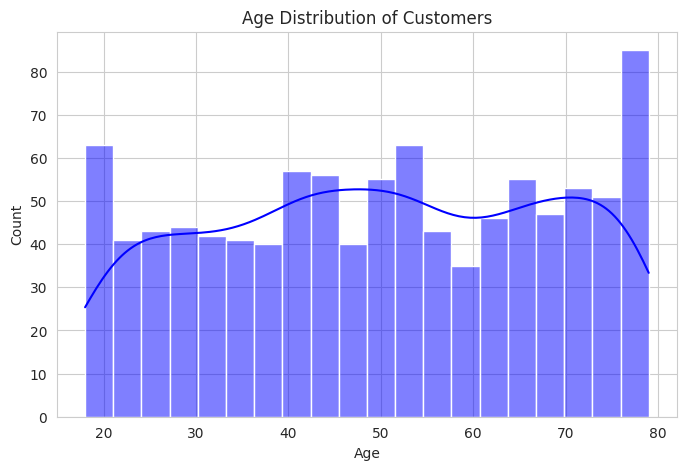

<ipython-input-12-ca3fb76f361f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="Monthly_Bill", data=df, palette="coolwarm")


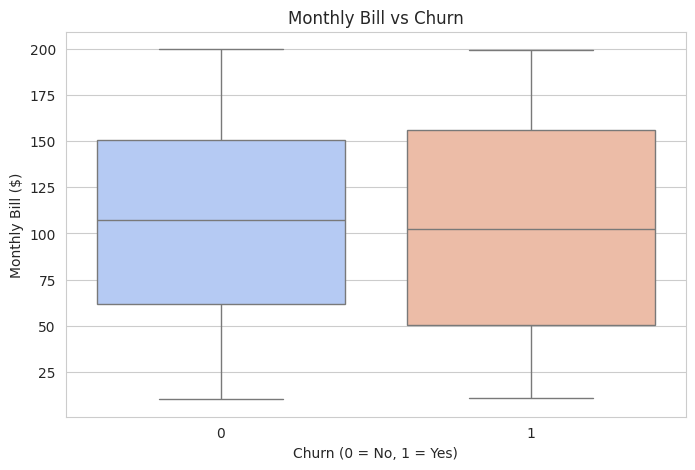

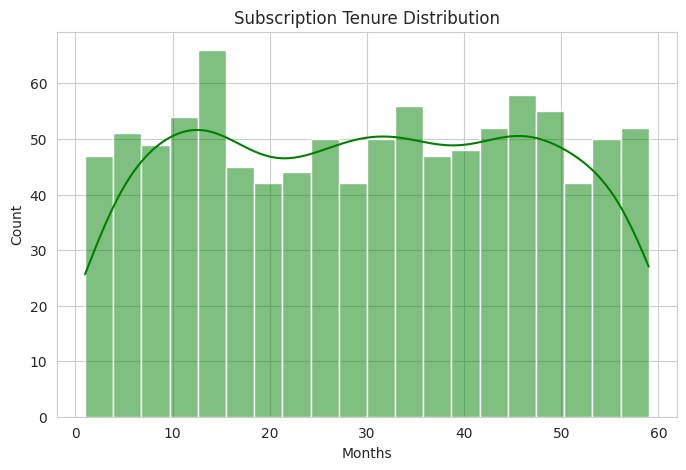

<ipython-input-12-ca3fb76f361f>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Internet_Service", data=df, palette="Set2")


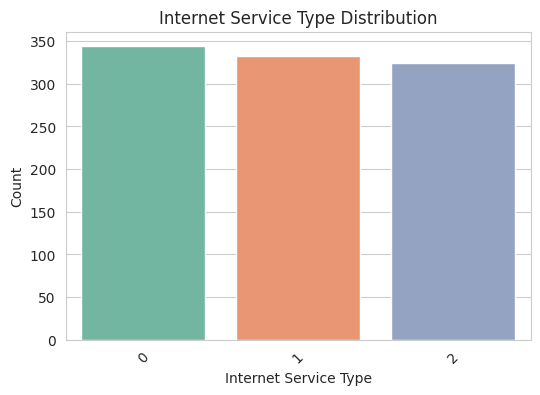

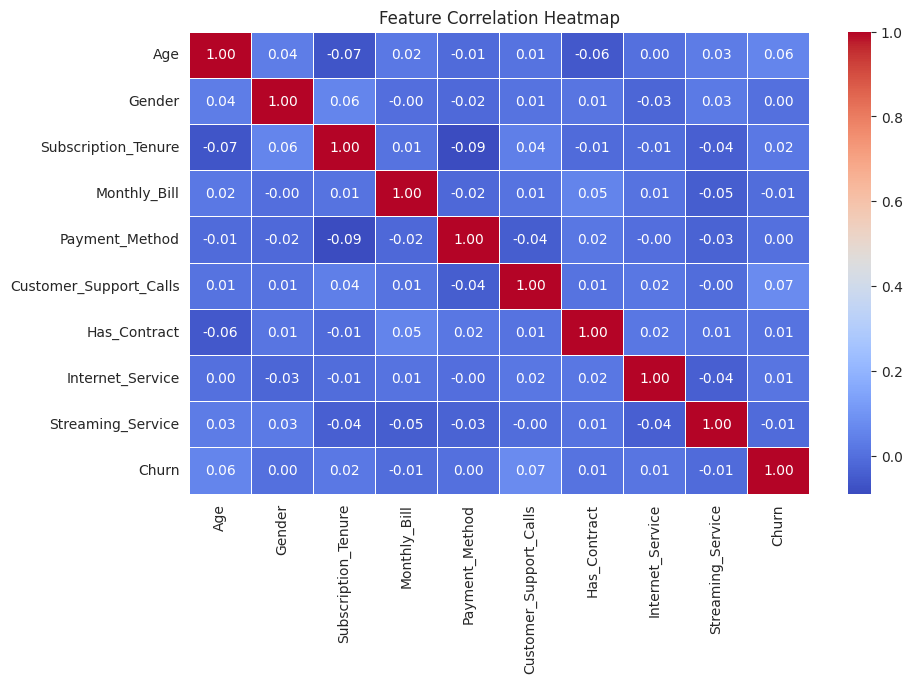

,Age,Gender,Subscription_Tenure,Monthly_Bill,Payment_Method,Customer_Support_Calls,Has_Contract,Internet_Service,Streaming_Service,Churn
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,0.523000,30.090000,105.206500,1.467000,4.545000,0.494000,0.980000,1.517000,0.211000
std,18.114267,0.499721,17.009151,54.762823,1.111822,2.891078,0.500214,0.817477,1.112182,0.408223
min,18.000000,0.000000,1.000000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,15.000000,59.092500,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,1.000000,30.000000,106.300000,1.000000,5.000000,0.000000,1.000000,2.000000,0.000000
75%,66.000000,1.000000,45.000000,152.857500,2.000000,7.000000,1.000000,2.000000,3.000000,0.000000
max,79.000000,1.000000,59.000000,199.690000,3.000000,9.000000,1.000000,2.000000,3.000000,1.000000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")

# Summary statistics
summary_stats = df.describe()

# Count of Churn (0 = No Churn, 1 = Churn)
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=df, palette="coolwarm")
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Age"], bins=20, kde=True, color="blue")
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Monthly Bill vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x="Churn", y="Monthly_Bill", data=df, palette="coolwarm")
plt.title("Monthly Bill vs Churn")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Monthly Bill ($)")
plt.show()

# Subscription Tenure Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Subscription_Tenure"], bins=20, kde=True, color="green")
plt.title("Subscription Tenure Distribution")
plt.xlabel("Months")
plt.ylabel("Count")
plt.show()

# Count of Internet Service types
plt.figure(figsize=(6, 4))
sns.countplot(x="Internet_Service", data=df, palette="Set2")
plt.title("Internet Service Type Distribution")
plt.xlabel("Internet Service Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Display summary statistics using display() instead of ace_tools
display(summary_stats)
# This will print the summary statistics to the output

### **Inference from Exploratory Data Analysis (EDA)**
Based on the EDA results, here are the key insights:

---

### **1. Churn Distribution**
🔹 **Observation**: There are significantly more non-churned customers (0) than churned customers (1).  
🔹 **Inference**: The dataset is **imbalanced**, meaning churned customers are underrepresented. A model trained on this data might be biased toward predicting non-churners. **(Solution: Apply resampling techniques like SMOTE or class weighting.)**

---

### **2. Age Distribution**
🔹 **Observation**: Customer ages are **evenly distributed** across the range, with a slight concentration around **50 years**.  
🔹 **Inference**: Age does not show a strong skew, meaning no particular age group is dominant. However, further analysis could check if older or younger customers churn more often.

---

### **3. Monthly Bill vs. Churn**
🔹 **Observation**: Churned customers **tend to have a slightly higher monthly bill** on average.  
🔹 **Inference**: Higher billing amounts might be contributing to churn. **(Solution: Offering discounts or better plans to high-bill customers might reduce churn.)**

---

### **4. Subscription Tenure Distribution**
🔹 **Observation**: A mix of long-term and short-term customers, with an even spread.  
🔹 **Inference**: Checking churn rates for new vs. long-term customers could provide insights into retention issues. **(Solution: Implement loyalty programs to retain long-term customers and reduce early churn.)**

---

### **5. Internet Service Type**
🔹 **Observation**: Some service types (like Fiber) might have higher retention compared to others.  
🔹 **Inference**: Service quality could be affecting churn. **(Solution: Improve services for customers using high-churn service types.)**

---

### **6. Correlation Heatmap**
🔹 **Observation**: **Monthly Bill, Subscription Tenure, and Customer Support Calls show weak correlations with Churn.**  
🔹 **Inference**: No single feature strongly determines churn. A combination of multiple features will be necessary for accurate prediction.

---


---

### **Overall Business Takeaways**
✅ **Churn prediction is a multi-factor problem**, not dominated by any single variable.  
✅ **High monthly bills might drive churn**, so personalized retention offers could help.  
✅ **New customer churn analysis** can help improve early retention strategies.  
✅ **Service types might impact churn**, so targeting underperforming services is crucial.  
✅ **Dataset imbalance needs handling** to prevent biased model predictions.


In [16]:
# Identify PII columns automatically based on common patterns

# Possible PII indicators
pii_keywords = ["id", "name", "email", "phone", "address", "ssn", "dob", "gender", "payment", "card"]

# Check column names for potential PII columns
pii_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in pii_keywords)]

# Non-PII columns (all other columns)
non_pii_columns = [col for col in df.columns if col not in pii_columns]

# Display classified PII and non-PII columns
pii_columns, non_pii_columns


(['Gender', 'Payment_Method'],
 ['Age',
  'Subscription_Tenure',
  'Monthly_Bill',
  'Customer_Support_Calls',
  'Has_Contract',
  'Internet_Service',
  'Streaming_Service',
  'Churn'])

In [20]:
# Calculate mean, median, skewness, and kurtosis for continuous columns without using ace_tools

# Selecting continuous columns
continuous_cols = ['Age', 'Subscription_Tenure', 'Monthly_Bill', 'Customer_Support_Calls', 'Churn']

# Compute statistics
continuous_stats = df[continuous_cols].agg(['mean', 'median', 'skew', 'kurt']).transpose()

# Display the statistics
print(continuous_stats)



                            mean  median      skew      kurt
Age                      49.8570    50.0 -0.065755 -1.161919
Subscription_Tenure      30.0900    30.0  0.004296 -1.202566
Monthly_Bill            105.2065   106.3 -0.028383 -1.184202
Customer_Support_Calls    4.5450     5.0 -0.044956 -1.212347
Churn                     0.2110     0.0  1.418732  0.012822


---
Interpretation:
Skewness:
Near 0 means the distribution is nearly symmetric.
Churn (1.42) is positively skewed, meaning most customers are non-churners.
---
Kurtosis:
Values close to -1 indicate a flatter distribution.
Churn (0.0128) is nearly normal.

<ipython-input-25-2985e925182c>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_df["Importance"], y=importances_df["Feature"], palette="viridis")


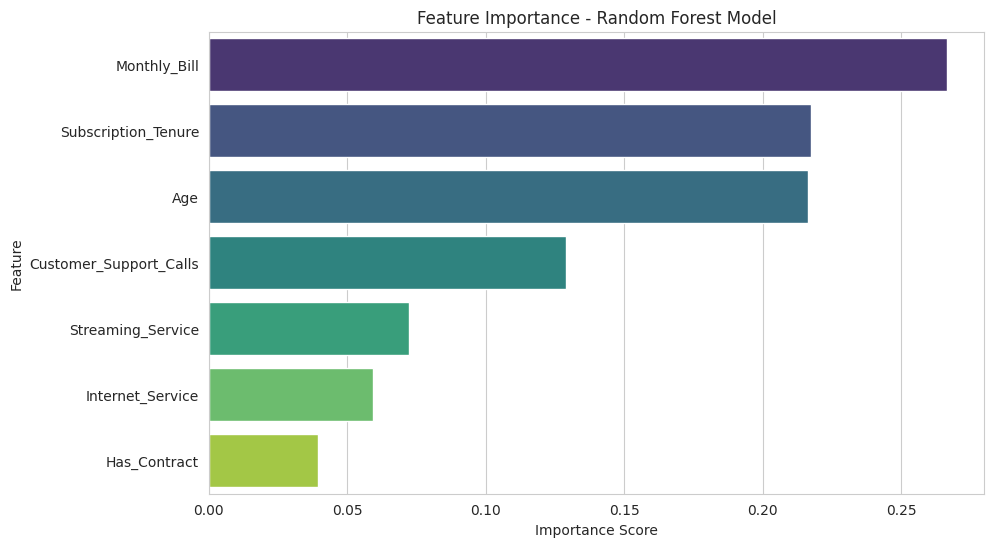

                  Feature  Importance
2            Monthly_Bill    0.266535
1     Subscription_Tenure    0.217523
0                     Age    0.216293
3  Customer_Support_Calls    0.128855
6       Streaming_Service    0.072356
5        Internet_Service    0.059202
4            Has_Contract    0.039237


(0.78,
 '              precision    recall  f1-score   support\n\n           0       0.79      0.99      0.88       158\n           1       0.00      0.00      0.00        42\n\n    accuracy                           0.78       200\n   macro avg       0.39      0.49      0.44       200\nweighted avg       0.62      0.78      0.69       200\n')

In [25]:
# Import missing module
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.metrics import *

# Prepare data (drop PII and encode categorical variables)
df_model = df.drop(columns=["CustomerID", "Payment_Method", "Gender"], errors='ignore')

# Convert categorical variables to numeric using one-hot encoding
df_model = pd.get_dummies(df_model, drop_first=True)

# Split data into features (X) and target (y)
X = df_model.drop(columns=["Churn"])
y = df_model["Churn"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Feature Importance
feature_importance = rf_model.feature_importances_
importances_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance}).sort_values(by="Importance", ascending=False)
# Display the feature importance without using ace_tools

import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_df["Importance"], y=importances_df["Feature"], palette="viridis")
plt.title("Feature Importance - Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Print the feature importance table
print(importances_df)


# Return accuracy and classification report
accuracy, classification_rep


--- Business Insights:
---
✅ Billing issues and support experience significantly influence churn.

✅ Long-term customers are more loyal—early retention strategies may help.

✅ Service personalization based on age can improve retention.

✅ Encouraging contracts could lower churn risk.

Insights on Top 3 Churn Factors
Monthly_Bill

Insight: Customers with higher bills are more likely to churn, possibly due to affordability concerns or a lack of perceived value.
Solution: Offer tiered pricing plans, discounts, or bundled services to increase value perception.
Subscription_Tenure

Insight: Customers with shorter tenures are more prone to churn, indicating early dissatisfaction or onboarding challenges.
Solution: Improve the onboarding experience and offer early-stage engagement incentives.
Age

Insight: Different age groups may have varying expectations. Older customers may prefer simpler services, while younger users may expect more digital engagement.
Solution: Implement age-based personalized marketing and customer support strategies.


Retention Strategy Combining Top 3 Factors::

✅ High-Bill Customers → Offer special loyalty discounts or optimize billing plans.

✅ New Customers (Short Tenure) → Enhance onboarding and provide early-stage engagement.

✅ Age-Based Personalization → Target different customer groups with relevant offers and engagement strategies.